In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import SnowballStemmer

import matplotlib.pyplot as plt
import string
import re

In [3]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [4]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 'Other Apple product or service', 'iPhone']
google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']

df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2409
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [9]:
df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     5346
Google    2985
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     8331 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [11]:
df2 = df.dropna(axis = 0)
df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     8331 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [12]:
df2_label = pd.DataFrame(df2['emotion'].copy())
emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                "Positive emotion" : 0, 
                                "No emotion toward brand or product" : 2,
                                "I can't tell" : 3}})
df2['emotion'] = emotion
df2

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,0
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,0
3,@sxsw I hope this year's festival isn't as cra...,Apple,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0
...,...,...,...
9087,Ipad everywhere. #SXSW {link},Apple,0
9088,"Wave, buzz... RT @mention We interrupt your re...",Google,2
9089,"Google's Zeiger, a physician never reported po...",Google,2
9090,Some Verizon iPhone customers complained their...,Apple,2


In [13]:
sw = stopwords.words('english')
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)
stemmer = SnowballStemmer(language = 'english')
def preprocess_text(text, tokenizer, sw, stemmer):
    # Standardize case (lowercase the text)
    # your code here
    text = text.lower()
    
    token = tokenizer.tokenize(text)
    
    text = [word for word in token if word not in sw]

    final = [stemmer.stem(text) for text in text]
    
    return final

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]

    return ' '.join(doc)

In [14]:
X = df2.drop(columns = 'emotion')
y = df2['emotion']

text_series = df["tweet_text"].map(lambda x : preprocess_text(x, tokenizer, sw, stemmer))
text_series

0       [wesley83, iphon, hrs, tweet, rise_austin, dea...
1       [jessede, know, fludapp, awesom, ipad, iphon, ...
2              [swonderlin, wait, ipad, also, sale, sxsw]
3       [sxsw, hope, year, festiv, crashi, year, iphon...
4       [sxtxstate, great, stuff, fri, sxsw, marissa, ...
                              ...                        
9087                        [ipad, everywher, sxsw, link]
9088    [wave, buzz, mention, interrupt, regular, sche...
9089    [googl, zeiger, physician, never, report, pote...
9090    [verizon, iphon, custom, complain, time, fell,...
9091    [ûârt, mention, googl, test, ûïcheck, offer, s...
Name: tweet_text, Length: 9092, dtype: object

In [15]:
X_t, X_val, y_t, y_val = train_test_split(X['tweet_text'], y, random_state=42)

In [16]:
cv = CountVectorizer(max_features = 1000)
X_t_vec = cv.fit_transform(X_t)
#print(X_t_vec)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)

In [17]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [18]:
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [19]:
y_preds = mnb.predict(X_val_vec)
print("Training Accuracy:", accuracy_score(y_val, y_preds))

Training Accuracy: 0.6135381661065771


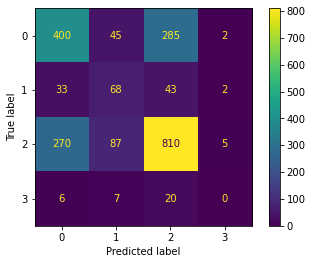

In [20]:
cm = confusion_matrix(y_val, y_preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot();

In [21]:
display(df2["emotion"].value_counts(normalize = True))
print('--------------------------')
display(df2["product"].value_counts(normalize = True))

2    0.557796
0    0.355900
1    0.068299
3    0.018005
Name: emotion, dtype: float64

--------------------------


Apple     0.6417
Google    0.3583
Name: product, dtype: float64

Model to find what emotion these tokenized texts refer to. Do we need to undersample to fix class imbalance? 
Or does that not matter since we are only caring about Apple rather than Apple + Google ?


In [22]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
textclassifier =Pipeline([
   ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB(alpha =0.1)),   
])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X['tweet_text'], y,
                                                    test_size = 0.5, random_state=42)

textclassifier.fit(X_train, y_train)
y_pred = textclassifier.predict(X_test)
print("Training Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.5669707153144503


In [25]:
# from keras.preprocessing import sequence
# X_train, X_test, y_train, y_test = train_test_split(X['tweet_text'], y,
#                                                     test_size = 0.5, random_state=42)
# top_words = 5000
# max_words = 20
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [26]:
# oversample = SMOTE()
# # transform the dataset
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# X_test, y_test = oversample.fit_resample(X_test, y_test)

In [27]:
# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X['tweet_text'], y, random_state=42)

X_t_vec = cv.fit_transform(X_train_grid)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)

param_grid = {
    "criterion":['gini', 'entropy'], 
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1, 10),
    "min_samples_leaf":range(1, 10)

}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_t_vec,y_train_grid)

In [28]:
# grid_search.best_params_

Optimal Parameters (?) Found - Pre TFID and SMOTE:

{'criterion': 'gini',

 'max_depth': 50,
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 9}

param_grid = {
    "criterion": 'gini', 
    "max_depth": 50,
    "min_samples_split": 1,
    "min_samples_leaf": 6
}

In [29]:
first_textclassifier =Pipeline([
   ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(random_state=42)),
   ('rf', RandomForestClassifier())
])

In [30]:
#Redoing with TFID and SMOTE
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X['tweet_text'], 
                                                                        y, random_state=42)

first_textclassifier.fit(X_train_grid, y_train_grid)
y_pred = first_textclassifier.predict(X_test_grid)
print("Training Accuracy:", accuracy_score(y_test_grid, y_pred))

Training Accuracy: 0.6361017762842055


In [31]:
# #Commented out due to block taking 5.2 minutes to run. 


# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X['tweet_text'], 
#                                                                         y, random_state=42)

# early_textclassifier =Pipeline([
#    ('vect', CountVectorizer()),
#    ('tfidf', TfidfTransformer()),
#    ('smote', SMOTE(random_state=42)),
#    ('rf', RandomForestClassifier())])


# param_grid = {
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)

# }            


# grid = GridSearchCV(early_textclassifier, param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid.fit(X_train_grid, y_train_grid)   


In [32]:
# print('Best score and parameter combination = ')

# print(grid.best_score_)    
# print(grid.best_params_)      

Best score and parameter combination = 
0.631084835868695
{'rf__criterion': 'gini', 'rf__max_depth': 50, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4}

In [33]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X['tweet_text'], 
                                                                        y, random_state=42)
                                                                        
next_textclassifier = Pipeline([
   ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
   ('smote', SMOTE(sampling_strategy = 'minority', random_state=42)),
   ('rf', RandomForestClassifier(max_depth = 50, min_samples_leaf = 1, min_samples_split = 4, random_state=42))])

next_textclassifier.fit(X_train_grid, y_train_grid)
y_pred = next_textclassifier.predict(X_test_grid)
print("Training Accuracy:", accuracy_score(y_test_grid, y_pred))

Training Accuracy: 0.6120979356697072


Training Accuracy: 0.6212193951032166


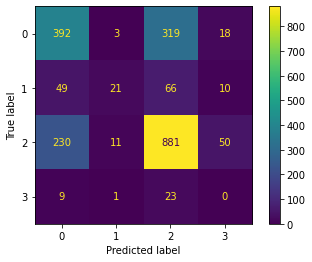

In [34]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

mnb_cv = imbpipeline(steps=[
    ('preprocess', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_t, y_t)
preds = mnb_cv.predict(X_val)
print("Training Accuracy:", mnb_cv.score(X_val, y_val))
#mnb.fit(X_train, y_train)
#preds = mnb_cv.predict(X_train)
cm2 = confusion_matrix(y_val, preds)
cm2display = ConfusionMatrixDisplay(cm2)
cm2display.plot();

Modifying NB model code with no-modified Random Forest Classifier

Training Accuracy: 0.6096975516082573


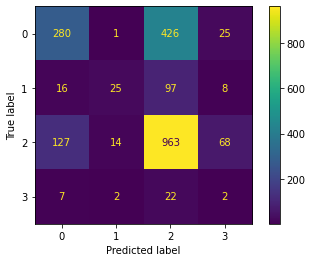

In [35]:


rf_basic_cv = imbpipeline(steps=[
    ('preprocess', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('rf', RandomForestClassifier(random_state=42))

])

rf_basic_cv.fit(X_t, y_t)
preds = rf_basic_cv.predict(X_val)
print("Training Accuracy:", rf_basic_cv.score(X_val, y_val))

cm_rf_basic = confusion_matrix(y_val, preds)
cm_rf_display = ConfusionMatrixDisplay(cm_rf_basic)
cm_rf_display.plot();

Let's try again with optimized parameters from a new gridsearch on the current pipeline.

In [53]:
#Code block has been commented out as it takes 2.3 minutes to run.


# X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X['tweet_text'], 
#                                                                         y, random_state=42)

# rf_basic_cv = imbpipeline(steps=[
#     ('preprocess', CountVectorizer()),
#     ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
#     ('rf', RandomForestClassifier(random_state=42))

# ])


# param_grid = {
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)

# }            


# grid = GridSearchCV(rf_basic_cv, param_grid, cv = 5, n_jobs = -1, verbose = 1)
# grid.fit(X_train_grid, y_train_grid)   


In [55]:
# print('Best score and parameter combination = ')

# print(grid.best_score_)    
# print(grid.best_params_)      

Best score and parameter combination = 
0.5742654923939151
{'rf__criterion': 'gini', 'rf__max_depth': 50, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4}


Training Accuracy: 0.5871339414306289


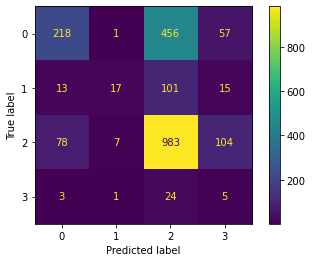

In [38]:
rf_optimal_cv = imbpipeline(steps=[
    ('preprocess', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('rf', RandomForestClassifier(criterion = 'gini', max_depth = 50, min_samples_leaf = 1,\
                                  min_samples_split = 4, random_state=42))

])


rf_optimal_cv.fit(X_train_grid, y_train_grid)
preds = rf_optimal_cv.predict(X_test_grid)
print("Training Accuracy:", rf_optimal_cv.score(X_test_grid, y_test_grid))

cm_rf_optimal = confusion_matrix(y_test_grid, preds)
cm_rf__opt_display = ConfusionMatrixDisplay(cm_rf_optimal)
cm_rf__opt_display.plot();